# Homework 4 Task 2 - False Color Imagery Analysis

**Author**: Jay Kim

**Github Repository**: https://github.com/jwonyk/eds220-hwk4

## About

### Purpose

The purpose of this project is to explore and analyze wildfire impacts in the Palisade-Eaton region using a fire perimeter data and Landsat 8 remote sensing imagery. The analysis includes importing, examining combination of datasets, restoring missing CRS information, generate both true and false color images, and plot the map to visualize. After reviewing this notebook, the audience will understand how to manipulate a geospatial raster and vector data, interpret spectral bands, and create visualizations the current environmental analysis in Python. 

### Highlights

- Restore missing CRS from a Landsat NetCDF file
- Create true and false-color images to visualize vegetation, burned areas, and the landscape condition.
- Identify cloud outliers and handle NaN values to improve image clarity
- Overlay false-color imagery with the fire perimeter to illustrate aftermath of wildfire

### About the data

#### Fire Perimeter Dataset

The fire perimeter dataset contains boundaries for the Eaton and Palisade fires. The original data comes from NIFC FIRIS (Fire Integrated Real-time Intelligence System). The data provides daily fire growth during the event of wildfire. The dataset is accessed through Los Angeles GeoHub and it is also accesscible from NIFC FIRIS public ArcGIS service.

#### Landsat NetCDF Dataset

The Landsat used in this analysis is a Landsat 8 Collection Level-2 Surface Reflectance product accessed through the Microsoft Planetary Computer Data Catalogue. The dataset includes multiple spectral bands stored in a NetCDF structure, CRS information, coordinate dimensions, and metadata. The spectral bands will assist to create true and false-color composite images for post-fire assessment.

### Reference

- Los Angeles GeoHub / NIFC FIRIS. (2025). _Palisades–Eaton dissolved fire perimeters_ [data file]. Available: https://geohub.lacity.org/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about. [Accessed: Nov. 15, 2025]

- U.S. Geological Survey. _Landsat Collection 2 Level-2 Surface Reflectance (Microsoft Planetary Computer version)_ [data file]. Available: https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2. [Accessed: Nov. 15, 2025]


In [6]:
# Import packages for this project
import os
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import geopandas as gpd

# Set pandas to display all columns
pd.set_option("display.max_columns", None)

## Fire Perimeter Data Exploration

In [7]:
# Load fire perimeter datasets
eaton = gpd.read_file(os.path.join('data',
                                      'fire_perimeters',
                                      'Eaton_Perimeter_20250121.geojson'))

palisades = gpd.read_file(os.path.join('data',
                                      'fire_perimeters',
                                      'Palisades_Perimeter_20250121.geojson'))

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   OBJECTID       20 non-null     int64   
 1   type           20 non-null     object  
 2   Shape__Area    20 non-null     float64 
 3   Shape__Length  20 non-null     float64 
 4   geometry       20 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 932.0+ bytes


(None,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 0     POLYGON ((-118.10094 34.16681, -118.10090 34.1...
 1     POLYGON ((-118.13596 34.17789, -118.13593 34.1...
 2     POLYGON ((-118.15626 34.18045, -118.15643 34.1...
 3     POLYGON ((-118.08442 34.18090, -118.08445 34.1...
 4     POLYGON ((-118.15659 34.18148, -118.15659 34.1...
 5     POLYGON ((-118.10616 34.18327, -118.10622 34.1...
 6     POLYGON ((-118.11317 34.18429, -118.11317 34.1...
 7     POLYGON ((-118.10578 34.18497, -118.10576 34.1...
 8     POLYGON ((-118.13770 34.18523, -118.13766 34.1...
 9     POLYGON ((-118.15697 34.18552, -118.15696 34.1...
 10    POLYGON ((-118.15394 34.18781, -118.15378 34.1...
 11    POLYGON ((-118.16031 34.19172, -118.16

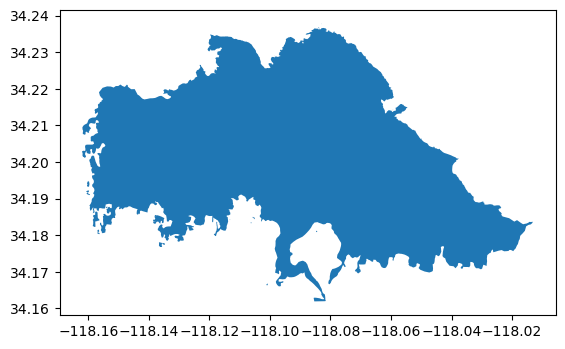

In [8]:
# Explore Eaton datasets
eaton.info(), eaton.crs, eaton.geometry, eaton.plot()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   OBJECTID       21 non-null     int64   
 1   type           21 non-null     object  
 2   Shape__Area    21 non-null     float64 
 3   Shape__Length  21 non-null     float64 
 4   geometry       21 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 972.0+ bytes


(None,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 0     POLYGON ((-118.51962 34.03061, -118.51962 34.0...
 1     POLYGON ((-118.51944 34.03176, -118.51944 34.0...
 2     POLYGON ((-118.52011 34.03244, -118.52011 34.0...
 3     POLYGON ((-118.52061 34.03235, -118.52063 34.0...
 4     POLYGON ((-118.52560 34.03302, -118.52560 34.0...
 5     POLYGON ((-118.52286 34.03427, -118.52283 34.0...
 6     POLYGON ((-118.52276 34.03435, -118.52273 34.0...
 7     POLYGON ((-118.51818 34.03739, -118.51820 34.0...
 8     POLYGON ((-118.53964 34.03715, -118.53971 34.0...
 9     POLYGON ((-118.51748 34.03607, -118.51752 34.0...
 10    POLYGON ((-118.51841 34.03892, -118.51841 34.0...
 11    POLYGON ((-118.51960 34.03911, -118.51

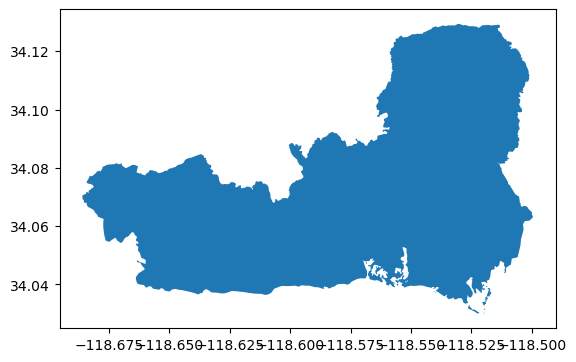

In [9]:
# Explore Palisades datasets
palisades.info(), palisades.crs, palisades.geometry, palisades.plot()

#### Fire Perimeter Data Summary
- Both Eaton and Palisades have a matching CRS (EPSG: 4326)
- Both Eaton and Palisades have **geophraphic** CRS.
- Both datasets have same structure:
    * GIS fields (OBJECTID, type, Shape_Area, Shape_Length)
    * Polygon geometry representing each fire final perimeter.

## NetCDF Data Import & Exploration

In [10]:
# Import NetCDF dataset
landsat = xr.open_dataset("data/landsat8-2025-02-23-palisades-eaton.nc")

# Inspect the dataset
landsat

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...

In [11]:
# Explore the landsat data
landsat.dims, landsat.coords, landsat.data_vars, landsat.info()

xarray.Dataset {
dimensions:
	y = 1418 ;
	x = 2742 ;

variables:
	float64 y(y) ;
		y:units = metre ;
		y:resolution = -30.0 ;
		y:crs = EPSG:32611 ;
		y:axis = Y ;
		y:long_name = y coordinate of projection ;
		y:standard_name = projection_y_coordinate ;
	float64 x(x) ;
		x:units = metre ;
		x:resolution = 30.0 ;
		x:crs = EPSG:32611 ;
		x:axis = X ;
		x:long_name = x coordinate of projection ;
		x:standard_name = projection_x_coordinate ;
	datetime64[ns] time() ;
	float32 red(y, x) ;
		red:grid_mapping = spatial_ref ;
	float32 green(y, x) ;
		green:grid_mapping = spatial_ref ;
	float32 blue(y, x) ;
		blue:grid_mapping = spatial_ref ;
	float32 nir08(y, x) ;
		nir08:grid_mapping = spatial_ref ;
	float32 swir22(y, x) ;
		swir22:grid_mapping = spatial_ref ;
	int64 spatial_ref() ;
		spatial_ref:crs_wkt = PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["

(FrozenMappingWarningOnValuesAccess({'y': 1418, 'x': 2742}),
 Coordinates:
   * y        (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
   * x        (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
     time     datetime64[ns] 8B ...,
 Data variables:
     red          (y, x) float32 16MB ...
     green        (y, x) float32 16MB ...
     blue         (y, x) float32 16MB ...
     nir08        (y, x) float32 16MB ...
     swir22       (y, x) float32 16MB ...
     spatial_ref  int64 8B ...,
 None)

#### Landsat NetCDF Dataset Summary

The description in the metadata is explain in the following:
- Dimension: 
    * `x` : 2742 pixels wide (east to west) and has 30 m resolution
    * `y` : 1418 pixels tall (north to south) and has -30 m resolution
    * `time` : one value in datetime64 format
- Coordinates:
    * `x` : Projected coordinates in meters and includes resolution, axis label, and CRS
    * `y` : Projected coordinates in meters and includes resolution, axis label, and CRS
    * `time` : Acquisition date / time of the Landsat scene
    * `spatial_ref` : An integer placeholder coordinate with projection metadata such as CRS WKT, ellipsoid data, transform, latitude and longtitude, etc.
- Data Variables:
    * All colors have reflectance values mapped through the `spacial_ref` 
    * `red` : float32 format; red band
    * `green` : float32 format; green band
    * `blue` : float32 format; blue band
    * `nir08` : float32 format; Near-Infrared (NIR) band for vegetation monitoring and false-color imagery
    * `swir22` : float32 format; Shortwave Infrared 2 (SWIR2) for burn areas and moisture analysis
    * `spatial_ref` : int64 format; variable contains projection metadata
- Additional note:
    * All CRS information is stored inside the `spatial_ref` variable
    * CRS set to WGS 84 (EPSG: 32611) and it is **projected** coordinate system (Area of use: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA)).


## Restore Geospatial Information (CRS Recovery)

#### a. Check if dataset has a CRS

In [12]:
# Use `rio.crs` to print what is the CRS of this dataset
landsat.rio.crs # Does not return anything

#### b. Retrieve CRS from `spatial_ref`

In [15]:
# Print the CRS by using accesing the `spatial_ref.crs_wkt`
landsat.spatial_ref.crs_wkt # Projected - WGS 84

'PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]'

#### c. Write the CRS back into the dataset

In [ ]:
# Use the `.rio.write_crs()` method


## True Color Image

## False Color Image

## Map with Fire Perimeters